Calculate the Ground State Energy of the Water Molecule

In [1]:
import numpy as np
import pylab

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_algorithms import NumPyMinimumEigensolver

from qiskit_algorithms.optimizers import SLSQP

from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_algorithms import VQE
from qiskit.primitives import Estimator

In [2]:
driver = PySCFDriver(atom='O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0', charge=0, spin=0, basis='sto3g')
molecule = driver.run()

In [3]:
transformer = FreezeCoreTransformer()
transformed_molecule = transformer.transform(molecule)
mapper = ParityMapper(num_particles=transformed_molecule.num_particles)

algo = NumPyMinimumEigensolver()
algo.filter_criterion = transformed_molecule.get_default_filter_criterion()
solver = GroundStateEigensolver(mapper, algo)
op, _ = solver.get_qubit_operators(transformed_molecule)
result = solver.solve(transformed_molecule)
print(f'Number of qubits: {op.num_qubits}, number of paulis: {len(op.paulis)}')
print(result)

Number of qubits: 10, number of paulis: 551
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.206272446429
  - computed part:      -23.544497240444
  - FreezeCoreTransformer extracted energy part: -60.661775205985
~ Nuclear repulsion energy (Hartree): 9.193913160623
> Total ground state energy (Hartree): -75.012359285806
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 8.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  2.21475902  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  1.578672632401  0.0]
    - computed part:      [0.0  1.577787979435  0.0]
    - FreezeCoreTransformer extracted energy part: [0.0  0.000884652966  0.0]
  > Dipole moment (a.u.): [0.0  0.636086387599  0.0]  Total: 0.636086387599
                 (debye): [0.0  1.616770178304  0.0]  Total: 1.616770178304
 


Using VQE

In [4]:
tapered_mapper = transformed_molecule.get_tapered_mapper(mapper)
estimator = Estimator()

optimizer = SLSQP(maxiter=10000, ftol=1e-9)
ansatz = UCCSD(
    transformed_molecule.num_spatial_orbitals,
    transformed_molecule.num_particles,
    tapered_mapper,
    initial_state=HartreeFock(
    transformed_molecule.num_spatial_orbitals,
    transformed_molecule.num_particles,
    tapered_mapper,
    )
)

/var/folders/6g/tntccqg91tx89k0bx3d_v4m00000gp/T/ipykernel_54665/451791638.py:2: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


# Z-matrix - Keep the Bond angles constant but vary one of the bond length of O-H

In [5]:
distances = [x * 0.01 + 1.0 for x in range(15)]
energies = np.empty(len(distances))

for i, distance in enumerate(distances):
    driver = PySCFDriver(f'H; O 1 1.08; H 2 {distance} 1 104.5', basis='sto3g')
    molecule = driver.run()
    transformer = FreezeCoreTransformer()
    transformed_molecule = transformer.transform(molecule)
    mapper = ParityMapper(num_particles=transformed_molecule.num_particles)
    algo = NumPyMinimumEigensolver()
    algo.filter_criterion = transformed_molecule.get_default_filter_criterion()
    solver = GroundStateEigensolver(mapper, algo)
    result = solver.solve(transformed_molecule)
    energies[i] = result.total_energies[0]

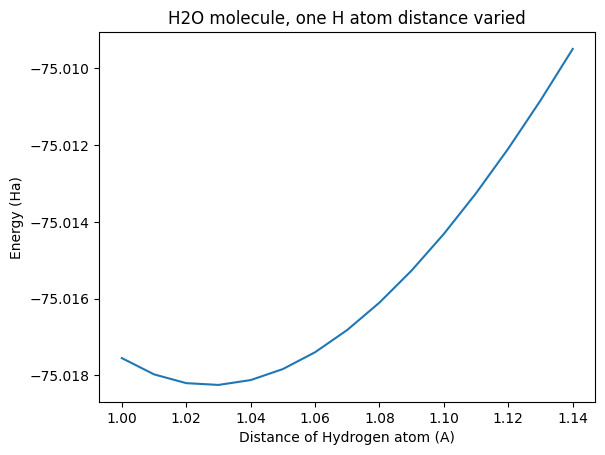

In [6]:
pylab.plot(distances, energies)
pylab.xlabel('Distance of Hydrogen atom (A)')
pylab.ylabel('Energy (Ha)')
pylab.title('H2O molecule, one H atom distance varied')
pylab.show()